National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Applied Statistics

Final Project: Treatment for Malocclusion

Student: Andrei Batyrov (Fall2022)

Date: 19-Oct-2023

##### Table of Contents

1. [Description](#description)

2. [Analysis](#analysis)

    2.1. [Causal effect of Treatment on dANB](#treat_danb)

    2.2. [Causal effect of Treatment on Growth](#treat_growth)

3. [Discussion](#discussion)

In [1]:
# Essential import
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.calibration import CalibratedClassifierCV
from causalinference import CausalModel
from scipy.stats import ttest_ind, ttest_rel, norm, chi2_contingency
from scipy.stats.contingency import crosstab
import matplotlib.pyplot as plt
#from IPython.display import Image
alpha = 0.05 # significance level

---
##### <a id="description"></a>1. Description

In this assignment you are going to analyse scull measurement data of patients with malocclusion. Patients affected by Class III malocclusion (characterised by the protrusion of lower dental arch) suffer from a skeletal imbalance that is established early in life, and that becomes more pronounced during puberty and until skeletal maturation is complete. Predicting treatment success or failure early in a single Class III patient makes it easier to correct it, but it is difficult to do just from a small number of morphometric determinants is problematic. The reason for that is that Class III malocclusion is rarely a consequence of an abnormality in a single craniofacial component, so individual clinical and radiological measurements are likely to be less indicative than the interplay between the measurements themselves.

The data set we will use contains 143 patients with two sets of measurements at ages T1 and T2 (measured in years) for the following variables:
- Treatment: untreated (0) or treated (1)
- Growth: a binary variable with values Good or Bad, determined on the basis of CoGn-CoA
- ANB: angle between Down's points A and B (degrees)
- IMPA: incisor-mandibular plane angle (degrees)
- PPPM: palatal plane - mandibular plane angle (degrees)
- CoA: total maxillary length from condilion to Down's point A (mm)
- GoPg: length of mandibular body from gonion to pogonion (mm)
- CoGo: length of mandibular ramus from condilion to pogonion (mm)

All the measurements are taken from x-ray scans using a set of reference points established using a map like the following:

In [2]:
#Image('skull.png', width='25%')

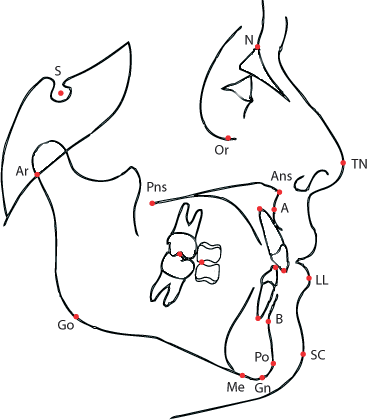

Fig. 1. Skull map

For simplicity, we transform the dataset by taking differences between time points T2 and T1, so all features now represent changes in measurements:
`malocclusion.csv`
We would like to estimate the effect of the treatment on Growth and dANB by taking into account causal relationships between variables. Our knowledge of those causal relationships is represented on the following DAG:

In [3]:
#Image('DAG.png', width='50%')

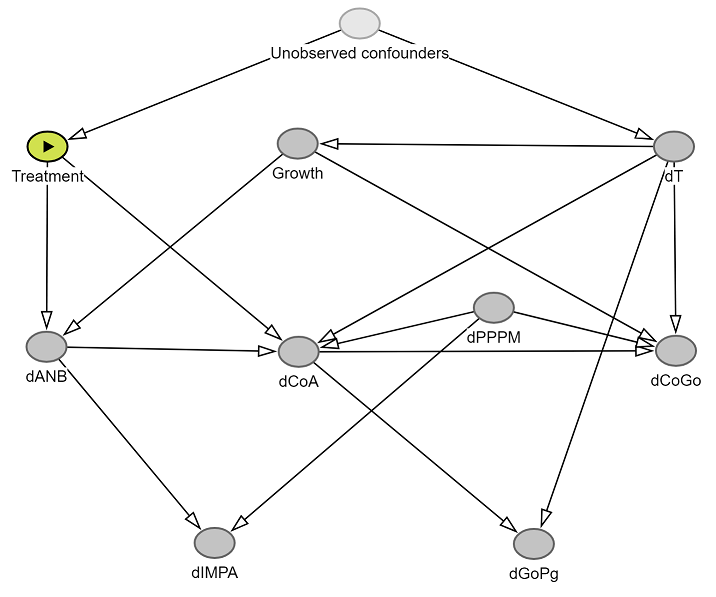

<a id="dag"></a>Fig. 2. Causal DAG

Treatment assignment, Growth and number of years between two measurements are likely to be affected by some unobserved confounders, as the graph shows.

Given the graph, select the variables to condition on, apply suitable adjustment method, and calculate your estimates of causal effects: Treatment on Growth, Treatment on dANB, both ATE and ATET.

Your analysis should contain:

- Selection of covariates to adjust for (informed by the graph)
- Application of the most suitable adjustment method
- Estimates of the ATE and ATET

The maximal grade for the assignment is 25 points , where for each of two estimated causal effects you could get:
- a maximum of 6.5 points for correct and optimal selection of the adjustment set,
- a maximum of 3 points for correct estimation of the ATE,
- a maximum of 3 points for correct estimation of the ATET.

---
##### <a id="assignment"></a>2. Assignment

In [4]:
# Helper functions
def resample_via_bootstrap(array, n_resamples):
    '''
    Resample via bootstrap.
    '''
    indices = np.random.randint(0, len(array), (n_resamples, len(array)))
    resamples = array[indices]
    return resamples

def percentile_interval(stat, alpha):
    '''
    Return two-sided percentiles.
    '''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def estimate_via_dr(data, Y, T, X):
    '''
    Estimate via Doubly Robust.
    '''
    # Build two linear models
    y0 = LinearRegression().fit(data[data[T] == 0][X], data[data[T] == 0][Y]).predict(data[X])
    y1 = LinearRegression().fit(data[data[T] == 1][X], data[data[T] == 1][Y]).predict(data[X])

    # Calculate DR estimators
    dr0 = (1.0 - data[T]) * (data[Y] - y0) / (1.0 - data['e']) + y0
    dr1 = data[T]  * (data[Y] - y1) / data['e']  + y1
    return dr0, dr1

def t_test(a, b, kind):
    '''
    Perform two-sided two-sample t-test.
    Print results and return 95% confidence interval.
    a, b: samples
    kind: 'ind' (independent samples) | 'rel' (paired samples)
    '''
    if kind == 'ind':
        result = ttest_ind(a, b)
    elif kind == 'rel':
        result = ttest_rel(a, b)
    else:
        raise ValueError("kind should be 'ind' or 'rel'")
    ci_lo, ci_hi = result.confidence_interval()
    print('t-test summary:')
    print(f'statistic = {result.statistic:.4f}')
    if result.pvalue < alpha:
        print(f'p-value   = \033[32m{result.pvalue:.2e}\033[0m ({alpha = })')
    else:
        print(f'p-value   = \033[31m{result.pvalue:.2e}\033[0m ({alpha = })')
    print(f'95% CI    = [{ci_lo:.4f}, {ci_hi:.4f}]')
    return ci_lo, ci_hi

In [5]:
malocclusion_dict = {'Growth':{0:0,1:1,2:0,3:0,4:0,5:1,6:1,7:1,8:0,9:0,10:0,11:0,12:1,13:0,14:0,15:0,16:0,17:0,18:1,19:0,20:0,21:1,22:1,23:0,24:1,25:0,26:0,27:0,28:0,29:0,30:0,31:0,32:0,33:0,34:0,35:0,36:1,37:1,38:1,39:0,40:0,41:0,42:0,43:1,44:0,45:0,46:0,47:1,48:0,49:1,50:0,51:0,52:1,53:1,54:0,55:0,56:0,57:0,58:0,59:1,60:0,61:1,62:0,63:0,64:0,65:0,66:0,67:0,68:0,69:0,70:0,71:0,72:1,73:0,74:0,75:0,76:0,77:0,78:0,79:0,80:0,81:0,82:0,83:1,84:0,85:0,86:0,87:0,88:1,89:0,90:0,91:0,92:0,93:1,94:0,95:0,96:0,97:0,98:0,99:0,100:0,101:0,102:0,103:0,104:0,105:1,106:1,107:0,108:0,109:0,110:1,111:1,112:1,113:1,114:1,115:1,116:1,117:1,118:1,119:1,120:1,121:1,122:1,123:1,124:1,125:1,126:1,127:1,128:1,129:1,130:1,131:1,132:1,133:1,134:1,135:1,136:1,137:1,138:1,139:1,140:1,141:1,142:1},'Treatment':{0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:1,9:0,10:0,11:1,12:0,13:0,14:1,15:0,16:0,17:1,18:0,19:1,20:0,21:0,22:0,23:1,24:0,25:1,26:0,27:0,28:0,29:1,30:1,31:1,32:1,33:0,34:0,35:0,36:0,37:0,38:0,39:0,40:1,41:0,42:1,43:0,44:0,45:0,46:1,47:0,48:1,49:0,50:0,51:0,52:0,53:0,54:1,55:0,56:0,57:1,58:0,59:0,60:0,61:0,62:1,63:1,64:1,65:1,66:0,67:0,68:1,69:1,70:0,71:0,72:0,73:0,74:1,75:0,76:0,77:0,78:0,79:0,80:0,81:1,82:0,83:0,84:1,85:1,86:0,87:0,88:0,89:0,90:1,91:1,92:0,93:0,94:0,95:0,96:1,97:1,98:0,99:1,100:0,101:0,102:0,103:1,104:0,105:0,106:0,107:0,108:0,109:1,110:0,111:1,112:1,113:1,114:1,115:1,116:1,117:1,118:1,119:1,120:1,121:1,122:1,123:1,124:1,125:1,126:1,127:1,128:1,129:1,130:1,131:1,132:1,133:1,134:1,135:1,136:1,137:1,138:1,139:1,140:1,141:1,142:1},'dANB':{0:-3.2,1:-0.6,2:-1.6,3:-1.1,4:-1.1,5:-0.6,6:-1.2,7:-0.1,8:0.6,9:-3.0,10:-0.6,11:0.2,12:-2.1,13:-2.3,14:2.1,15:-3.2,16:-1.9,17:1.2,18:-1.5,19:-0.4,20:-1.3,21:-0.9,22:-3.3,23:2.5,24:-0.5,25:-1.4,26:-1.0,27:-2.1,28:-0.9,29:-0.3,30:-1.9,31:2.1,32:-0.1,33:-2.8,34:-2.9,35:-3.0,36:0.8,37:0.4,38:-1.0,39:-0.7,40:-0.3,41:-1.2,42:1.4,43:4.9,44:-3.8,45:0.7,46:0.8,47:-1.2,48:1.5,49:-0.4,50:-0.2,51:-0.6,52:0.4,53:0.5,54:3.1,55:0.2,56:-3.1,57:0.7,58:-3.5,59:-1.8,60:0.2,61:0.5,62:3.3,63:1.5,64:1.9,65:-0.3,66:-1.7,67:-1.4,68:-1.0,69:-2.3,70:-1.7,71:-4.2,72:-1.1,73:-1.8,74:-0.5,75:-0.4,76:0.0,77:-0.7,78:-1.4,79:2.0,80:-0.9,81:-2.2,82:-0.2,83:0.2,84:2.0,85:-2.1,86:-2.0,87:-0.9,88:0.0,89:-2.5,90:-0.1,91:0.9,92:2.0,93:-0.7,94:-2.6,95:-2.7,96:0.0,97:-0.2,98:-2.1,99:-1.0,100:-2.5,101:-1.1,102:-3.2,103:0.0,104:-1.3,105:0.3,106:-0.6,107:-5.1,108:0.4,109:-1.2,110:0.0,111:1.1,112:1.0,113:2.1,114:1.1,115:3.7,116:1.7,117:1.4,118:0.9,119:1.5,120:3.2,121:1.9,122:2.2,123:2.0,124:-1.0,125:-0.9,126:3.9,127:0.8,128:3.1,129:2.5,130:1.0,131:2.1,132:0.1,133:2.2,134:-0.2,135:0.6,136:-0.4,137:3.5,138:0.8,139:2.1,140:-0.2,141:1.5,142:1.3},'dCoA':{0:1.0,1:2.59999999999999,2:4.3,3:14.1,4:7.7,5:0.0999999999999943,6:1.59999999999999,7:2.5,8:5.09999999999999,9:11.9,10:-0.299999999999997,11:11.9,12:0.599999999999994,13:5.5,14:10.7,15:1.3,16:8.5,17:11.2,18:4.0,19:11.6,20:2.09999999999999,21:1.7,22:8.09999999999999,23:7.59999999999999,24:1.90000000000001,25:10.8,26:4.7,27:-0.900000000000006,28:1.3,29:6.0,30:8.0,31:14.5,32:8.90000000000001,33:8.40000000000001,34:8.2,35:1.90000000000001,36:0.700000000000003,37:3.3,38:3.0,39:7.8,40:13.1,41:-0.400000000000006,42:11.7,43:0.799999999999997,44:1.7,45:6.5,46:13.6,47:1.40000000000001,48:13.2,49:2.0,50:9.3,51:0.400000000000006,52:6.3,53:0.700000000000003,54:10.2,55:1.5,56:5.59999999999999,57:10.1,58:2.7,59:0.5,60:1.7,61:3.90000000000001,62:11.9,63:5.7,64:7.8,65:2.09999999999999,66:2.0,67:5.7,68:4.7,69:10.3,70:0.700000000000003,71:1.7,72:1.5,73:1.3,74:3.3,75:5.59999999999999,76:1.7,77:4.09999999999999,78:3.5,79:11.6,80:1.09999999999999,81:9.7,82:1.40000000000001,83:2.40000000000001,84:10.9,85:2.3,86:0.900000000000006,87:11.4,88:7.5,89:0.0,90:8.5,91:5.5,92:12.7,93:1.3,94:2.90000000000001,95:2.40000000000001,96:5.8,97:10.0,98:0.900000000000006,99:9.8,100:7.3,101:1.59999999999999,102:1.7,103:11.2,104:0.5,105:1.59999999999999,106:1.09999999999999,107:8.0,108:4.3,109:7.90000000000001,110:0.5,111:14.7,112:9.7,113:11.1,114:6.2,115:1.90000000000001,116:5.09999999999999,117:7.8,118:20.0,119:5.5,120:10.7,121:12.1,122:9.7,123:11.7,124:13.1,125:10.6,126:15.6,127:2.09999999999999,128:15.4,129:5.5,130:10.3,131:5.40000000000001,132:9.2,133:4.90000000000001,134:6.59999999999999,135:11.2,136:2.3,137:9.8,138:2.7,139:8.2,140:6.8,141:4.59999999999999,142:7.0},'dCoGo':{0:3.7,1:1.4,2:7.1,3:17.5,4:11.0,5:0.899999999999999,6:3.0,7:0.100000000000001,8:8.7,9:16.5,10:4.4,11:17.3,12:3.3,13:8.1,14:11.4,15:4.1,16:8.9,17:10.9,18:9.2,19:13.1,20:6.2,21:4.1,22:9.0,23:3.4,24:-2.6,25:14.1,26:5.4,27:-0.200000000000003,28:4.0,29:7.5,30:8.2,31:10.4,32:10.8,33:10.9,34:8.1,35:6.2,36:-0.700000000000003,37:3.4,38:-1.3,39:9.3,40:17.4,41:-1.3,42:10.8,43:2.2,44:1.8,45:6.6,46:16.4,47:1.6,48:13.9,49:2.3,50:7.7,51:3.0,52:4.5,53:-0.100000000000001,54:11.0,55:4.8,56:5.0,57:6.6,58:5.9,59:2.4,60:2.1,61:1.0,62:11.7,63:5.5,64:6.3,65:2.6,66:3.6,67:16.2,68:7.4,69:15.0,70:2.1,71:4.09999999999999,72:0.700000000000003,73:8.0,74:11.2,75:5.1,76:-0.399999999999999,77:9.0,78:4.5,79:13.4,80:2.7,81:11.0,82:2.7,83:1.4,84:3.1,85:1.2,86:4.1,87:11.6,88:3.4,89:5.7,90:8.3,91:7.3,92:10.7,93:4.1,94:0.700000000000003,95:0.100000000000001,96:6.9,97:8.2,98:4.0,99:12.4,100:8.4,101:4.3,102:6.5,103:13.2,104:3.1,105:0.799999999999997,106:2.9,107:15.3,108:8.90000000000001,109:11.1,110:2.5,111:9.9,112:8.9,113:13.1,114:6.2,115:0.600000000000001,116:2.09999999999999,117:9.9,118:13.3,119:7.8,120:5.5,121:11.9,122:9.0,123:8.0,124:10.7,125:11.4,126:11.7,127:4.0,128:9.6,129:1.8,130:10.3,131:1.4,132:9.7,133:2.5,134:7.0,135:12.0,136:4.4,137:9.6,138:3.3,139:9.1,140:10.9,141:6.2,142:6.00000000000001},'dGoPg':{0:4.0,1:-0.0999999999999943,2:4.2,3:20.7,4:8.8,5:-1.0,6:1.7,7:4.09999999999999,8:5.09999999999999,9:14.7,10:2.4,11:16.2,12:1.09999999999999,13:6.8,14:13.6,15:5.7,16:12.8,17:16.4,18:1.7,19:11.4,20:1.90000000000001,21:2.0,22:16.5,23:8.8,24:1.9,25:13.7,26:5.7,27:1.9,28:2.90000000000001,29:11.0,30:12.9,31:15.0,32:13.3,33:11.4,34:13.0,35:6.59999999999999,36:-1.0,37:5.8,38:5.1,39:12.8,40:16.1,41:3.3,42:18.3,43:1.2,44:2.8,45:5.7,46:14.1,47:1.3,48:16.4,49:-0.799999999999997,50:10.3,51:3.7,52:7.90000000000001,53:3.2,54:10.0,55:3.0,56:11.9,57:9.40000000000001,58:8.2,59:-0.299999999999997,60:2.8,61:6.2,62:17.3,63:7.3,64:11.8,65:5.59999999999999,66:5.40000000000001,67:6.3,68:7.09999999999999,69:13.2,70:1.0,71:6.90000000000001,72:3.1,73:3.2,74:2.0,75:5.3,76:0.900000000000006,77:4.7,78:4.5,79:16.2,80:1.8,81:11.0,82:1.3,83:5.1,84:17.6,85:5.7,86:2.9,87:15.7,88:10.3,89:-1.4,90:6.8,91:6.3,92:13.4,93:2.40000000000001,94:6.0,95:1.90000000000001,96:7.7,97:13.5,98:6.2,99:9.40000000000001,100:12.8,101:3.7,102:5.3,103:17.3,104:1.2,105:-0.200000000000003,106:4.5,107:23.3,108:5.7,109:10.5,110:3.40000000000001,111:17.4,112:7.90000000000001,113:12.9,114:7.90000000000001,115:4.3,116:2.7,117:11.3,118:17.2,119:8.3,120:11.3,121:12.9,122:4.40000000000001,123:12.7,124:16.7,125:11.6,126:15.7,127:2.40000000000001,128:13.0,129:5.7,130:4.5,131:5.90000000000001,132:18.8,133:0.0999999999999943,134:6.0,135:10.7,136:3.5,137:11.4,138:2.0,139:12.8,140:3.40000000000001,141:6.5,142:4.5},'dIMPA':{0:-4.2,1:3.8,2:-6.0,3:-12.1,4:-6.7,5:-1.09999999999999,6:1.8,7:1.59999999999999,8:0.599999999999994,9:0.400000000000006,10:-4.0,11:5.5,12:-0.799999999999997,13:3.7,14:-0.0999999999999943,15:1.3,16:-2.40000000000001,17:-3.8,18:-5.0,19:-1.0,20:-3.7,21:-1.90000000000001,22:3.2,23:12.0,24:6.3,25:-11.0,26:5.8,27:0.299999999999997,28:-2.09999999999999,29:-9.40000000000001,30:0.299999999999997,31:7.59999999999999,32:-1.5,33:0.599999999999994,34:-1.2,35:-10.9,36:-2.40000000000001,37:1.8,38:-2.0,39:0.400000000000006,40:-0.299999999999997,41:-3.2,42:-6.3,43:-0.700000000000003,44:-3.09999999999999,45:-3.09999999999999,46:4.40000000000001,47:3.7,48:-4.09999999999999,49:1.09999999999999,50:3.90000000000001,51:0.900000000000006,52:-8.3,53:1.09999999999999,54:-8.3,55:2.8,56:-0.5,57:-8.09999999999999,58:6.5,59:7.0,60:1.5,61:-3.5,62:-6.09999999999999,63:-12.7,64:-3.90000000000001,65:-7.7,66:-0.5,67:4.5,68:0.799999999999997,69:-1.3,70:5.0,71:-2.0,72:-2.90000000000001,73:-3.3,74:6.09999999999999,75:-1.90000000000001,76:2.59999999999999,77:0.200000000000003,78:2.0,79:0.400000000000006,80:4.3,81:-0.599999999999994,82:-2.2,83:2.0,84:-18.6,85:-6.2,86:-2.7,87:-3.7,88:3.90000000000001,89:-3.7,90:-6.8,91:-4.7,92:11.4,93:0.599999999999994,94:-1.09999999999999,95:-5.3,96:-2.90000000000001,97:1.3,98:-1.2,99:0.200000000000003,100:-1.40000000000001,101:-2.0,102:-2.90000000000001,103:3.2,104:-6.09999999999999,105:0.0999999999999943,106:1.40000000000001,107:-9.09999999999999,108:2.7,109:-6.7,110:3.0,111:3.5,112:0.900000000000006,113:2.0,114:-4.59999999999999,115:4.7,116:0.799999999999997,117:5.09999999999999,118:6.5,119:-0.400000000000006,120:-11.7,121:2.3,122:2.0,123:1.40000000000001,124:-4.09999999999999,125:3.2,126:11.1,127:-0.299999999999997,128:-2.3,129:-0.700000000000003,130:4.7,131:1.2,132:5.59999999999999,133:7.09999999999999,134:-4.59999999999999,135:2.2,136:-3.40000000000001,137:3.40000000000001,138:-2.0,139:1.40000000000001,140:-2.7,141:1.8,142:-19.0},'dPPPM':{0:-1.1,1:-0.5,2:-3.1,3:-2.1,4:0.0,5:-0.899999999999999,6:-1.8,7:-2.3,8:-0.899999999999999,9:-2.6,10:-1.6,11:-4.4,12:-2.4,13:-2.1,14:2.1,15:-2.7,16:2.1,17:-3.0,18:-3.6,19:-4.5,20:-3.4,21:-1.9,22:-2.5,23:-0.199999999999999,24:1.3,25:-1.0,26:-2.8,27:3.4,28:-1.7,29:-0.199999999999999,30:-2.5,31:-5.4,32:-5.7,33:-4.0,34:1.8,35:-2.3,36:0.6,37:0.0,38:-3.3,39:-3.6,40:-8.3,41:-2.0,42:3.0,43:-1.6,44:-3.6,45:-2.7,46:-7.1,47:-0.300000000000001,48:1.9,49:-2.9,50:-1.2,51:1.3,52:3.3,53:0.0,54:-0.100000000000001,55:-3.2,56:-2.6,57:-1.9,58:-0.9,59:-0.899999999999999,60:6.5,61:0.200000000000003,62:6.5,63:1.4,64:-1.7,65:3.6,66:-1.1,67:-3.0,68:-5.7,69:-6.5,70:-1.8,71:-2.2,72:1.9,73:-1.1,74:-2.3,75:-2.6,76:0.100000000000001,77:0.300000000000001,78:-0.399999999999999,79:-2.3,80:-2.2,81:-5.2,82:-1.7,83:-1.4,84:5.5,85:2.4,86:0.0,87:-1.4,88:-2.6,89:-1.4,90:-1.9,91:-0.600000000000001,92:-1.1,93:-1.8,94:-2.6,95:0.100000000000001,96:-1.6,97:-3.3,98:0.199999999999999,99:-8.7,100:2.2,101:-0.199999999999999,102:1.4,103:-2.3,104:2.8,105:-0.200000000000003,106:-0.800000000000001,107:-4.5,108:0.800000000000001,109:-2.2,110:0.600000000000001,111:-5.9,112:-0.299999999999997,113:-1.3,114:-0.399999999999999,115:-1.3,116:0.899999999999999,117:-3.3,118:-9.3,119:0.699999999999999,120:2.7,121:-2.8,122:-1.7,123:-6.5,124:-1.0,125:-0.100000000000001,126:1.4,127:-0.199999999999999,128:-3.8,129:-1.2,130:-3.0,131:1.0,132:-7.5,133:2.9,134:1.3,135:-0.800000000000001,136:1.2,137:-6.6,138:-2.1,139:0.699999999999999,140:-3.3,141:-3.5,142:-3.0},'dT':{0:5,1:3,2:5,3:9,4:5,5:3,6:3,7:2,8:3,9:11,10:1,11:7,12:3,13:6,14:6,15:3,16:6,17:7,18:5,19:6,20:2,21:2,22:11,23:4,24:1,25:9,26:3,27:1,28:1,29:5,30:8,31:5,32:7,33:6,34:6,35:5,36:1,37:1,38:2,39:5,40:6,41:3,42:8,43:3,44:2,45:4,46:6,47:3,48:7,49:2,50:6,51:2,52:8,53:1,54:5,55:1,56:5,57:4,58:3,59:4,60:1,61:4,62:10,63:4,64:5,65:3,66:2,67:3,68:3,69:8,70:1,71:4,72:1,73:7,74:4,75:3,76:1,77:5,78:6,79:11,80:2,81:5,82:1,83:3,84:7,85:4,86:2,87:8,88:3,89:2,90:5,91:6,92:10,93:3,94:3,95:3,96:5,97:7,98:4,99:7,100:8,101:1,102:3,103:8,104:3,105:1,106:4,107:12,108:4,109:6,110:2,111:8,112:4,113:9,114:5,115:4,116:3,117:8,118:7,119:6,120:7,121:8,122:6,123:6,124:6,125:3,126:6,127:4,128:6,129:4,130:4,131:3,132:9,133:2,134:5,135:7,136:5,137:7,138:5,139:10,140:4,141:5,142:2}}

In [6]:
# Load data
#malocclusion_data = pd.read_csv('./malocclusion.csv')
malocclusion_data = pd.DataFrame(malocclusion_dict)
N = malocclusion_data.shape[0]
malocclusion_data.iloc[np.random.choice(N, 5)]

,Growth,Treatment,dANB,dCoA,dCoGo,dGoPg,dIMPA,dPPPM,dT
114,1,1,1.1,6.2,6.2,7.9,-4.6,-0.4,5
44,0,0,-3.8,1.7,1.8,2.8,-3.1,-3.6,2
68,0,1,-1.0,4.7,7.4,7.1,0.8,-5.7,3
78,0,0,-1.4,3.5,4.5,4.5,2.0,-0.4,6
119,1,1,1.5,5.5,7.8,8.3,-0.4,0.7,6


In [7]:
malocclusion_data.isna().sum()

Growth       0
Treatment    0
dANB         0
dCoA         0
dCoGo        0
dGoPg        0
dIMPA        0
dPPPM        0
dT           0
dtype: int64

##### <a id="treat_danb"></a>2.1 Causal effect of Treatment on dANB

Let's determine our variables:
- $X$: valid adjustment set of known factors,
- $T$: treatment factor, which is `Treatment` in this case,
- $Y$: potential outcome, which is `dANB` in this case.

As per the DAG in Fig. [2](#dag), there is one directed path from `Treatment` to `dANB`. Besides the `Treatment` itself, there are several factors that can influence the potential outcome, which we need to adjust for. Factors `dIMPA`, `dGoPg`, `dCoGo` with their descendants `dCoA` and `dPPPM` are colliders and thus adjusting for them may introduce bias. The only collider-free undirected path from `Treatment` to `dANB` is shown below.

In [8]:
#Image('DAG_dANB.png', width='50%')

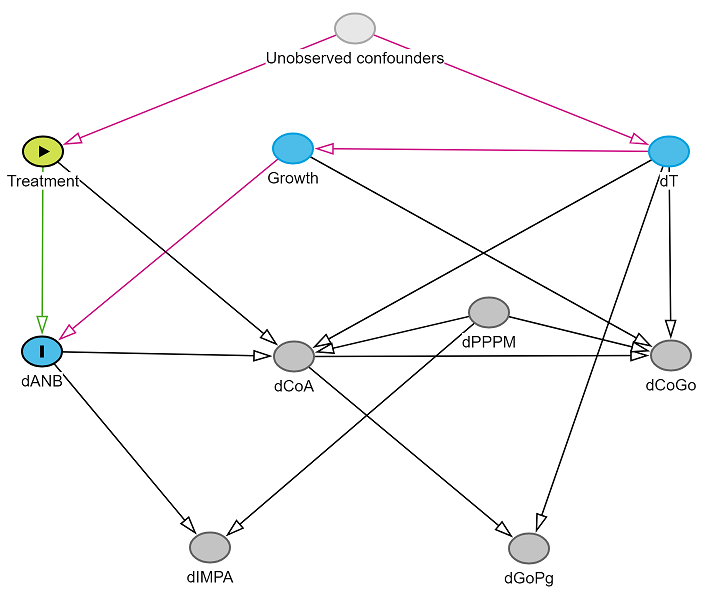

Fig. 3. Causal and biasing paths for outcome dANB

`dT` and `Growth` are the blockers on the path. These factors 1) do not have any descendants on the directed path from `Treatment` to `dANB` (except for descendants of `Treatment` that are not on the directed path from `Treatment` to `dANB`), 2) block all undirected paths from `Treatment` to `dANB`, which make them a valid adjustment set. Since, we cannot account for `Unobserved confounders`, we will not include it in the adjustment set.

So, our variables are:
- $X$ = $\{$ `dT`, `Growth` $\}$;
- $T$ = `Treatment`;
- $Y$ = `dANB`.

In [9]:
X = ['dT', 'Growth']
T = 'Treatment'
Y = 'dANB'

Since our data is not paired, we are facing the fundamental problem of causal inference: we are unable to observe the outcomes with and without the intervention (the treatment) at the same time, that is, we only have outcomes for either treated or untreated individuals. We can start with the baseline unadjusted average treatment effect (ATE) as a naive estimate. This effect is likely to be biased, since we do not account for other factors, as per our adjustment set.

In [10]:
E_Y_T0 = malocclusion_data[malocclusion_data[T] == 0][Y].mean() # Untreated
E_Y_T1 = malocclusion_data[malocclusion_data[T] == 1][Y].mean() # Treated

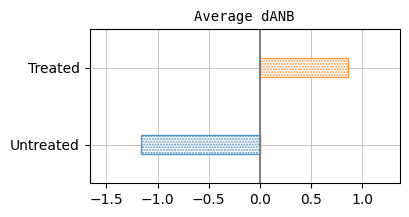

In [11]:
# Visually check average outcome for treated and untreated
plt.figure(figsize=(4, 2))
bars = plt.barh(['Untreated', 'Treated'], [E_Y_T0, E_Y_T1], height=0.25, align='center', color = 'white', alpha=0.75, hatch='.'*6)
plt.vlines(0, -0.5, 1.5, color='C7')
plt.xlim([min(E_Y_T1, E_Y_T0) - 0.5, max(E_Y_T1, E_Y_T0) + 0.5])
plt.ylim([-0.5, 1.5])
plt.title(f'Average {Y}', size=10, family='monospace')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
plt.gca().set_axisbelow(True)
plt.grid(lw=0.5)

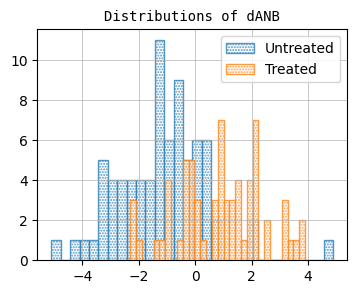

In [12]:
# Visually check difference between distributions of outcome for treated and untreated
plt.figure(figsize=(4, 3))
plt.hist(malocclusion_data[malocclusion_data[T] == 0][Y], bins=30, color = 'white', edgecolor='C0', alpha=0.75, hatch='.'*6, label='Untreated')
plt.hist(malocclusion_data[malocclusion_data[T] == 1][Y], bins=30, color = 'white', edgecolor='C1', alpha=0.75, hatch='.'*6, label='Treated')
plt.title(f'Distributions of {Y}', size=10, family='monospace')
plt.legend()
plt.grid(lw=0.5);

These distributions look different which may suggest the actual difference between the treated and untreated outcomes.

In [13]:
# ATE
ATE_unadj = E_Y_T1 - E_Y_T0
print(f'ATE on {Y} (Unadjusted) = {ATE_unadj:.4f};', end=' ')
# CI
# If we make no assumption about null distribution of ATE, we can use bootstrap to estimate confidence interval
E_Y_T0_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data[malocclusion_data[T] == 0][Y].values, 10000)))
E_Y_T1_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data[malocclusion_data[T] == 1][Y].values, 10000)))
ATE_unadj_boot = np.array(list(map(lambda x: x[0] - x[1], zip(E_Y_T1_boot, E_Y_T0_boot))))
ci = percentile_interval(ATE_unadj_boot, alpha)
print(f'95% CI (bootstrap) = [{ci[0]:.4f}, {ci[1]:.4f}]')
# To understand, if ATE is statistically significant, let's assume that null distribution of ATE is Student's t-distribution
# Our individuals are not matched yet, so we'll use two-sample independent t-test
ATE_unadj_lo, ATE_unadj_hi = t_test(malocclusion_data[malocclusion_data[T] == 1][Y], malocclusion_data[malocclusion_data[T] == 0][Y], 'ind')
# Note, that CIs obtained by bootstrapping and t-test are close

ATE on dANB (Unadjusted) = 2.0288; 95% CI (bootstrap) = [1.5258, 2.5197]
t-test summary:
statistic = 7.9381
p-value   = 5.81e-13 (alpha = 0.05)
95% CI    = [1.5235, 2.5340]


In [14]:
# ATET
ATET_unadj = ATE_unadj
print(f'ATET on {Y} (Unadjusted) = {ATET_unadj:.4f};', end=' ')
# CI
ATET_unadj_lo, ATET_unadj_hi = ATE_unadj_lo, ATE_unadj_hi
print(f'95% CI (t) = [{ATET_unadj_lo:.4f}, {ATET_unadj_hi:.4f}]')

ATET on dANB (Unadjusted) = 2.0288; 95% CI (t) = [1.5235, 2.5340]


Note: ATE / ATET are statistically significant.

Next we will apply five adjustment methods.

1. Ordinary Linear Regression (OLS)

In [15]:
# Fit OLS
model_linreg = smf.ols(f"{Y} ~ {' + '.join([T] + X)}", data=malocclusion_data)
fitted = model_linreg.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     32.12
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           7.78e-16
Time:                        14:41:24   Log-Likelihood:                -250.87
No. Observations:                 143   AIC:                             509.7
Df Residuals:                     139   BIC:                             521.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4021      0.276     -5.075      0.0

In [16]:
# ATE
print(f"Statistically significant OLS model's coefficients ({alpha = }):")
print(fitted.params[fitted.pvalues <= alpha].to_string(header=None))
ATE_OLS = fitted.params.loc['Treatment']
print(f'R-squared = {fitted.rsquared:.2f}')
print(f"ATE on {Y} (OLS) = {ATE_OLS:.4f}")

Statistically significant OLS model's coefficients (alpha = 0.05):
Intercept   -1.402079
Treatment    1.933583
Growth       1.144324
R-squared = 0.41
ATE on dANB (OLS) = 1.9336


Notes:
- $R^2 \approx 0.41$, that is the ordinary linear model can explain only around 41% of variance of `dANB`, which means that it is not a very good estimator, thus ATE / ATET can still remain biased;
- `dT` appeared to be a statistically _non_-significant factor. In this case we should exclude this factor from our adjustment set and repeat.

In [17]:
X.remove('dT') # remove `dT` as non-significant
X

['Growth']

In [18]:
# Fit OLS once again
model_linreg = smf.ols(f"{Y} ~ {' + '.join([T] + X)}", data=malocclusion_data)
fitted = model_linreg.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     48.04
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           1.31e-16
Time:                        14:41:24   Log-Likelihood:                -251.17
No. Observations:                 143   AIC:                             508.3
Df Residuals:                     140   BIC:                             517.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5600      0.181     -8.609      0.0

In [19]:
# ATE
print(f"Statistically significant OLS model's coefficients ({alpha = }):")
print(fitted.params[fitted.pvalues <= alpha].to_string(header=None))
# Either use the coefficient of `T`
ATE_OLS = fitted.params.loc[T]
# Or generate predictions of `Y` for `X`
E_Y_T1 = (fitted.params['Intercept'] + fitted.params[T] * 1 + fitted.params[X] * malocclusion_data[X]).mean()
E_Y_T0 = (fitted.params['Intercept'] + fitted.params[T] * 0 + fitted.params[X] * malocclusion_data[X]).mean()
ATE_OLS = (E_Y_T1 - E_Y_T0).values[0]
print(f'R-squared = {fitted.rsquared:.2f}')
print(f"ATE on {Y} (OLS) = {ATE_OLS:.4f};", end=' ')
# CI
ci = fitted._results.conf_int()[fitted.params.index.get_loc('Treatment')]
ATE_OLS_lo, ATE_OLS_hi = ci
print(f'95% CI = [{ATE_OLS_lo:.4f}, {ATE_OLS_hi:.4f}]')
if fitted.pvalues[T] < alpha:
    print(f'p-value = \033[32m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })')
else:
    print(f'p-value = \033[31m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })')

Statistically significant OLS model's coefficients (alpha = 0.05):
Intercept   -1.560045
Treatment    1.855994
Growth       1.173979
R-squared = 0.41
ATE on dANB (OLS) = 1.8560; 95% CI = [1.3809, 2.3311]
p-value = 1.96e-12 (alpha = 0.05)


In [20]:
# ATET
# Again, we can use either the coefficient of `T` (ATE)
ATET_OLS = ATE_OLS
# Or generate predictions of `Y` for `X|T=1`
E_Y_T1 = (fitted.params['Intercept'] + fitted.params[T] * 1 + fitted.params[X] * malocclusion_data[malocclusion_data[T] == 1][X]).mean()
E_Y_T0 = (fitted.params['Intercept'] + fitted.params[T] * 0 + fitted.params[X] * malocclusion_data[malocclusion_data[T] == 1][X]).mean()
ATET_OLS = (E_Y_T1 - E_Y_T0).values[0]
print(f"ATET on {Y} (OLS) = {ATET_OLS:.4f};", end=' ')
# CI
ATET_OLS_lo, ATET_OLS_hi = ATE_OLS_lo, ATE_OLS_hi
print(f'95% CI = [{ATET_OLS_lo:.4f}, {ATET_OLS_hi:.4f}]')

ATET on dANB (OLS) = 1.8560; 95% CI = [1.3809, 2.3311]


Notes:
- now we do not have any non-significant predictors in our model;
- $R^2 \approx 0.41$, which is still rather low, thus ATE / ATET can still remain biased;
- ATE / ATET are statistically significant.

2. Weighted Linear Regression with propensity score weighting (WLS)

In [21]:
# Calibrated classifier for propensity scores
model_logreg = CalibratedClassifierCV(LogisticRegression())
# Fit the classifier for X and T
model_logreg.fit(malocclusion_data[X], malocclusion_data[T])
# Calculate propensity scores
malocclusion_data['e'] = model_logreg.predict_proba(malocclusion_data[X])[:, 1].tolist()
# Calculate wights
malocclusion_data['w'] = malocclusion_data[T] / malocclusion_data['e'] + (1 - malocclusion_data[T]) / (1 - malocclusion_data['e'])
malocclusion_data.iloc[np.random.choice(N, 5)]

,Growth,Treatment,dANB,dCoA,dCoGo,dGoPg,dIMPA,dPPPM,dT,e,w
102,0,0,-3.2,1.7,6.5,5.3,-2.9,1.4,3,0.34318,1.522486
48,0,1,1.5,13.2,13.9,16.4,-4.1,1.9,7,0.34318,2.913927
73,0,0,-1.8,1.3,8.0,3.2,-3.3,-1.1,7,0.34318,1.522486
113,1,1,2.1,11.1,13.1,12.9,2.0,-1.3,9,0.42124,2.373942
42,0,1,1.4,11.7,10.8,18.3,-6.3,3.0,8,0.34318,2.913927


In [22]:
# Fit WLS
model_linreg = smf.wls(f"{Y} ~ {' + '.join([T] + X)}", data=malocclusion_data, weights=malocclusion_data['w'])
fitted = model_linreg.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.386
Model:                            WLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     44.06
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           1.44e-15
Time:                        14:41:24   Log-Likelihood:                -253.68
No. Observations:                 143   AIC:                             513.4
Df Residuals:                     140   BIC:                             522.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5572      0.205     -7.609      0.0

In [23]:
# ATE
print(f"Statistically significant WLS model's coefficients ({alpha = }):")
print(fitted.params[fitted.pvalues <= alpha].to_string(header=None))
# Either use the coefficient of `T`
ATE_WLS = fitted.params.loc[T]
# Or generate predictions of `Y` for `X`
E_Y_T1 = (fitted.params['Intercept'] + fitted.params[T] * 1 + fitted.params[X] * malocclusion_data[X]).mean()
E_Y_T0 = (fitted.params['Intercept'] + fitted.params[T] * 0 + fitted.params[X] * malocclusion_data[X]).mean()
ATE_WLS = (E_Y_T1 - E_Y_T0).values[0]
print(f'R-squared = {fitted.rsquared:.2f}')
print(f"ATE on {Y} (WLS) = {ATE_WLS:.4f};", end=' ')
# CI
ci = fitted._results.conf_int()[fitted.params.index.get_loc('Treatment')]
ATE_WLS_lo, ATE_WLS_hi = ci
print(f'95% CI = [{ATE_WLS_lo:.4f}, {ATE_WLS_hi:.4f}]')
if fitted.pvalues[T] < alpha:
    print(f'p-value = \033[32m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })')
else:
    print(f'p-value = \033[31m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })')

Statistically significant WLS model's coefficients (alpha = 0.05):
Intercept   -1.557166
Treatment    1.857007
Growth       1.168125
R-squared = 0.39
ATE on dANB (WLS) = 1.8570; 95% CI = [1.3803, 2.3337]
p-value = 2.22e-12 (alpha = 0.05)


In [24]:
# ATET
# Again, we can use either the coefficient of `T` (ATE)
ATET_WLS = ATE_WLS
# Or generate predictions of `Y` for `X|T=1`
E_Y_T1 = (fitted.params['Intercept'] + fitted.params[T] * 1 + fitted.params[X] * malocclusion_data[malocclusion_data[T] == 1][X]).mean()
E_Y_T0 = (fitted.params['Intercept'] + fitted.params[T] * 0 + fitted.params[X] * malocclusion_data[malocclusion_data[T] == 1][X]).mean()
ATET_WLS = (E_Y_T1 - E_Y_T0).values[0]
print(f"ATET on {Y} (WLS) = {ATET_WLS:.4f};", end=' ')
# CI
ATET_WLS_lo, ATET_WLS_hi = ATE_WLS_lo, ATE_WLS_hi
print(f'95% CI = [{ATET_WLS_lo:.4f}, {ATET_WLS_hi:.4f}]')

ATET on dANB (WLS) = 1.8570; 95% CI = [1.3803, 2.3337]


Notes:
- $R^2 \approx 0.39$, which is rather low again, thus ATE / ATET can still remain biased;
- ATE / ATET are statistically significant.

3. Doubly Robust estimator (DR)

In [25]:
malocclusion_data['DR0'], malocclusion_data['DR1'] = estimate_via_dr(malocclusion_data.copy(), Y, T, X)

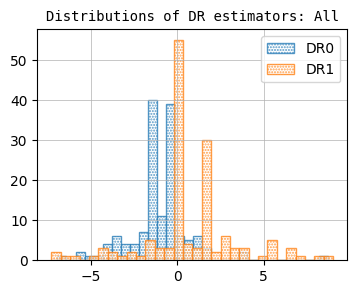

In [26]:
# Visually check difference between distributions of DR estimators
plt.figure(figsize=(4, 3))
plt.hist(malocclusion_data['DR0'], bins=30, color = 'white', edgecolor='C0', alpha=0.75, hatch='.'*6, label='DR0')
plt.hist(malocclusion_data['DR1'], bins=30, color = 'white', edgecolor='C1', alpha=0.75, hatch='.'*6, label='DR1')
plt.title('Distributions of DR estimators: All', size=10, family='monospace')
plt.legend()
plt.grid(lw=0.5);

In [27]:
# ATE
ATE_DR = malocclusion_data['DR1'].mean() - malocclusion_data['DR0'].mean()
print(f"ATE on {Y} (DR) = {ATE_DR:.4f};", end=' ')
# CI
# If we make no assumption about null distribution of ATE, we can use bootstrap to estimate confidence interval
dr0_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data['DR0'].values, 10000)))
dr1_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data['DR1'].values, 10000)))
ATE_DR_boot = np.array(list(map(lambda x: x[0] - x[1], zip(dr1_boot, dr0_boot))))
ci = percentile_interval(ATE_DR_boot, alpha)
print(f'95% CI (bootstrap) = [{ci[0]:.4f}, {ci[1]:.4f}]')
# To understand, if ATE is statistically significant, let's assume that null distribution of ATE is Student's t-distribution
# Our individuals are matched now, so we'll use two-sample paired t-test
ATE_DR_lo, ATE_DR_hi = t_test(malocclusion_data['DR1'], malocclusion_data['DR0'], 'rel')
# Note, that CIs obtained by bootstrapping and t-test are close

ATE on dANB (DR) = 1.8564; 95% CI (bootstrap) = [1.3396, 2.3762]
t-test summary:
statistic = 7.3085
p-value   = 1.79e-11 (alpha = 0.05)
95% CI    = [1.3543, 2.3585]


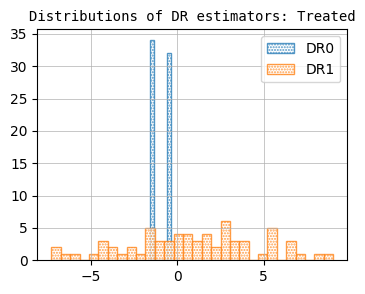

In [28]:
# Visually check difference between distributions of DR estimators for Treated
plt.figure(figsize=(4, 3))
plt.hist(malocclusion_data[malocclusion_data[T] == 1]['DR0'], bins=5, color = 'white', edgecolor='C0', alpha=0.75, hatch='.'*6, label='DR0')
plt.hist(malocclusion_data[malocclusion_data[T] == 1]['DR1'], bins=30, color = 'white', edgecolor='C1', alpha=0.75, hatch='.'*6, label='DR1')
plt.title('Distributions of DR estimators: Treated', size=10, family='monospace')
plt.legend()
plt.grid(lw=0.5);

In [29]:
# ATET
ATET_DR = malocclusion_data[malocclusion_data[T] == 1]['DR1'].mean() - malocclusion_data[malocclusion_data[T] == 1]['DR0'].mean()
print(f"ATET on {Y} (DR) = {ATET_DR:.4f};", end=' ')
# CI
# We have no assumption about null distribution of ATET, so, we will use bootstrap to estimate confidence interval
dr0_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data[malocclusion_data[T] == 1]['DR0'].values, 10000)))
dr1_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data[malocclusion_data[T] == 1]['DR1'].values, 10000)))
ATET_DR_boot = np.array(list(map(lambda x: x[0] - x[1], zip(dr1_boot, dr0_boot))))
ci = percentile_interval(ATET_DR_boot, alpha)
print(f'95% CI (bootstrap) = [{ci[0]:.4f}, {ci[1]:.4f}]')
# To understand, if ATE is statistically significant, let's assume that null distribution of ATET is Student's t-distribution
# Our individuals are matched now, so we'll use two-sample paired t-test
ATET_DR_lo, ATET_DR_hi = t_test(malocclusion_data[malocclusion_data[T] == 1]['DR1'], malocclusion_data[malocclusion_data[T] == 1]['DR0'], 'rel')
# Note, that CIs obtained by bootstrapping and t-test are close

ATET on dANB (DR) = 1.8523; 95% CI (bootstrap) = [0.9309, 2.7578]
t-test summary:
statistic = 4.0141
p-value   = 1.57e-04 (alpha = 0.05)
95% CI    = [0.9307, 2.7738]


Notes:
- propensity scores are obtained with a correct classification model (calibrated logistic regression classifier), so, estimates should be unbiased;
- ATE / ATET are statistically significant.

4. Machalanobis Distance Matching (MDM)

In [30]:
model_causal = CausalModel(Y=malocclusion_data[Y].values, D=malocclusion_data[T].values, X=malocclusion_data[X].values)
model_causal.est_via_matching(bias_adj=True)

c:\Users\andre\mambaforge\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [31]:
# Note, that `Raw-diff` confirms our naive estimate
print(model_causal.summary_stats)
print(model_causal.estimates)


Summary Statistics

                        Controls (N_c=77)          Treated (N_t=66)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -1.164        1.544        0.865        1.499        2.029

                        Controls (N_c=77)          Treated (N_t=66)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.338        0.476        0.485        0.504        0.300


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761

In [32]:
# ATE
ATE_MDM = model_causal.estimates['matching']['ate']
print(f"ATE on {Y} (MDM) = {ATE_MDM:.4f};", end=' ')
# CI
se = model_causal.estimates['matching']['ate_se']
ci = [ATE_MDM - norm.ppf(1 - alpha / 2) * se, ATE_MDM + norm.ppf(1 - alpha / 2) * se]
ATE_MDM_lo, ATE_MDM_hi = ci
print(f'95% CI = [{ATE_MDM_lo:.4f}, {ATE_MDM_hi:.4f}]')
# Unfortunately, CausalModel does not export p-value(s), but it is 0.0, as per the summary above 

ATE on dANB (MDM) = 1.8564; 95% CI = [1.3916, 2.3211]


In [33]:
# ATET
ATET_MDM = model_causal.estimates['matching']['att']
print(f"ATET on {Y} (MDM) = {ATET_MDM:.4f};", end=' ')
# CI
se = model_causal.estimates['matching']['att_se']
ci = [ATET_MDM - norm.ppf(1 - alpha / 2) * se, ATET_MDM + norm.ppf(1 - alpha / 2) * se]
ATET_MDM_lo, ATET_MDM_hi = ci
print(f'95% CI = [{ATET_MDM_lo:.4f}, {ATET_MDM_hi:.4f}]')

ATET on dANB (MDM) = 1.8523; 95% CI = [1.3822, 2.3223]


Notes:
- `X` is low-dimensional $(|X| = |\{ Growth \}| = 2)$, so, the estimates should be unbiased;
- ATE / ATET are statistically significant.

5. Propensity Score Matching (PSM)

In [34]:
model_causal = CausalModel(Y=malocclusion_data[Y].values, D=malocclusion_data[T].values, X=malocclusion_data['e'].values)
model_causal.est_via_matching(bias_adj=True)

In [35]:
# Note, that `Raw-diff` confirms our naive estimate
print(model_causal.summary_stats)
print(model_causal.estimates)


Summary Statistics

                        Controls (N_c=77)          Treated (N_t=66)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -1.164        1.544        0.865        1.499        2.029

                        Controls (N_c=77)          Treated (N_t=66)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.370        0.037        0.381        0.039        0.300


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761

In [36]:
# ATE
ATE_PSM = model_causal.estimates['matching']['ate']
print(f" ATE on {Y} (PSM) = {ATE_PSM:.4f};", end=' ')
# CI
se = model_causal.estimates['matching']['ate_se']
ci = [ATE_PSM - norm.ppf(1 - alpha / 2) * se, ATE_PSM + norm.ppf(1 - alpha / 2) * se]
ATE_PSM_lo, ATE_PSM_hi = ci
print(f'95% CI = [{ATE_PSM_lo:.4f}, {ATE_PSM_hi:.4f}]')
# Unfortunately, CausalModel does not export p-value(s), but it is 0.0, as per the summary above 

 ATE on dANB (PSM) = 1.8564; 95% CI = [1.3916, 2.3211]


In [37]:
# ATET
ATET_PSM = model_causal.estimates['matching']['att']
print(f"ATET on {Y} (PSM) = {ATET_PSM:.4f};", end=' ')
# CI
se = model_causal.estimates['matching']['att_se']
ci = [ATET_PSM - norm.ppf(1 - alpha / 2) * se, ATET_PSM + norm.ppf(1 - alpha / 2) * se]
ATET_PSM_lo, ATET_PSM_hi = ci
print(f'95% CI = [{ATET_PSM_lo:.4f}, {ATET_PSM_hi:.4f}]')

ATET on dANB (PSM) = 1.8523; 95% CI = [1.3822, 2.3223]


Notes:
- we use propensity scores as the valid adjustment set, and propensity scores are obtained with a correct classification model (calibrated logistic regression classifier in our case), so, the estimates should be unbiased;
- ATE / ATET are statistically significant.

Now let's compare our results and discuss them.

In [38]:
ATEs_df = pd.DataFrame({'ATE_lo': [ATE_unadj_lo, ATE_OLS_lo, ATE_WLS_lo, ATE_DR_lo, ATE_MDM_lo, ATE_PSM_lo],
                        'ATE':[ATE_unadj, ATE_OLS, ATE_WLS, ATE_DR, ATE_MDM, ATE_PSM],
                        'ATE_hi':[ATE_unadj_hi, ATE_OLS_hi, ATE_WLS_hi, ATE_DR_hi, ATE_MDM_hi, ATE_PSM_hi],
                        'ATET_lo': [ATET_unadj_lo, ATET_OLS_lo, ATET_WLS_lo, ATET_DR_lo, ATET_MDM_lo, ATET_PSM_lo],
                        'ATET':[ATET_unadj, ATET_OLS, ATET_WLS, ATET_DR, ATET_MDM, ATET_PSM],
                        'ATET_hi': [ATET_unadj_hi, ATET_OLS_hi, ATET_WLS_hi, ATET_DR_hi, ATET_MDM_hi, ATET_PSM_hi]}, 
                        index=['Unadjusted', 'OLS', 'WLS', 'DR', 'MDM', 'PSM'])
ATEs_df.style.format(formatter=lambda x: f'{x:.4f}').set_caption('<h4>ATE and ATET with 95% CI by adjustment method</h4>')

,ATE_lo,ATE,ATE_hi,ATET_lo,ATET,ATET_hi
Unadjusted,1.5235,2.0288,2.5340,1.5235,2.0288,2.5340
OLS,1.3809,1.8560,2.3311,1.3809,1.8560,2.3311
WLS,1.3803,1.8570,2.3337,1.3803,1.8570,2.3337
DR,1.3543,1.8564,2.3585,0.9307,1.8523,2.7738
MDM,1.3916,1.8564,2.3211,1.3822,1.8523,2.3223
PSM,1.3916,1.8564,2.3211,1.3822,1.8523,2.3223


In [39]:
# ATE adjustment method(s) with narrowest 95% CI
(ATEs_df['ATE_hi'] - ATEs_df['ATE_lo'])[np.isclose(ATEs_df['ATE_hi'] - ATEs_df['ATE_lo'], (ATEs_df['ATE_hi'] - ATEs_df['ATE_lo']).min())].index

Index(['MDM', 'PSM'], dtype='object')

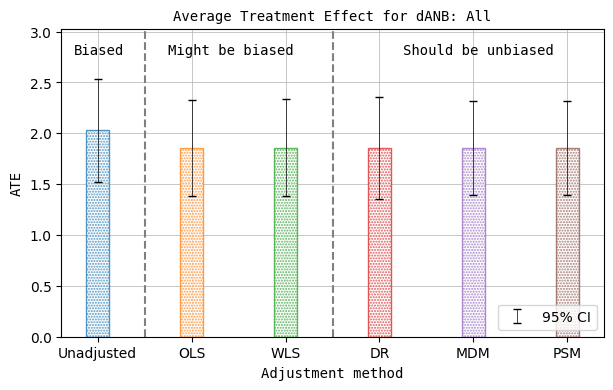

In [40]:
plt.figure(figsize=(7, 4))
bars = plt.bar(ATEs_df.index, 
               ATEs_df['ATE'], 
               yerr=[ATEs_df['ATE']-ATEs_df['ATE_lo'], ATEs_df['ATE_hi']-ATEs_df['ATE']], 
               width=0.25, align='center', color = 'white', alpha=0.75, hatch='.'*6, 
               error_kw={'lw': 0.5, 'capsize': 3, 'label': '95% CI'})
plt.vlines(0.5, ymin=0.0, ymax=ATEs_df['ATE'].max() + 1.0, ls='--', color='grey')
plt.vlines(2.5, ymin=0.0, ymax=ATEs_df['ATE'].max() + 1.0, ls='--', color='grey')
plt.text(-0.25, ATEs_df['ATE'].max() + 0.75, 'Biased', size=10, family='monospace')
plt.text(0.75, ATEs_df['ATE'].max() + 0.75, 'Might be biased', size=10, family='monospace')
plt.text(3.25, ATEs_df['ATE'].max() + 0.75, 'Should be unbiased', size=10, family='monospace')
plt.xlabel('Adjustment method', size=10, family='monospace')
plt.ylabel('ATE', size=10, family='monospace')
plt.title(f'Average Treatment Effect for {Y}: All', size=10, family='monospace')
plt.ylim([0.0, ATEs_df['ATE'].max() + 1.0])
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
plt.gca().set_axisbelow(True)
plt.legend(loc='lower right')
plt.grid(lw=0.5)

In [41]:
# ATET adjustment method(s) with narrowest 95% CI
(ATEs_df['ATET_hi'] - ATEs_df['ATET_lo'])[np.isclose(ATEs_df['ATET_hi'] - ATEs_df['ATET_lo'], (ATEs_df['ATET_hi'] - ATEs_df['ATET_lo']).min())].index

Index(['MDM', 'PSM'], dtype='object')

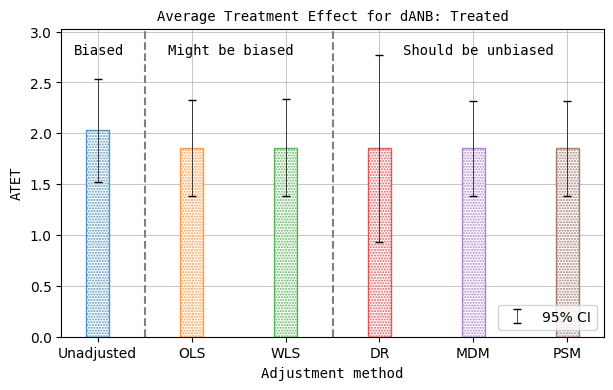

In [42]:
plt.figure(figsize=(7, 4))
bars = plt.bar(ATEs_df.index, 
               ATEs_df['ATET'], 
               yerr=[ATEs_df['ATET']-ATEs_df['ATET_lo'], ATEs_df['ATET_hi']-ATEs_df['ATET']], 
               width=0.25, align='center', color = 'white', alpha=0.75, hatch='.'*6, 
               error_kw={'lw': 0.5, 'capsize': 3, 'label': '95% CI'})
plt.vlines(0.5, ymin=0.0, ymax=ATEs_df['ATET'].max() + 1.0, ls='--', color='grey')
plt.vlines(2.5, ymin=0.0, ymax=ATEs_df['ATET'].max() + 1.0, ls='--', color='grey')
plt.text(-0.25, ATEs_df['ATET'].max() + 0.75, 'Biased', size=10, family='monospace')
plt.text(0.75, ATEs_df['ATET'].max() + 0.75, 'Might be biased', size=10, family='monospace')
plt.text(3.25, ATEs_df['ATET'].max() + 0.75, 'Should be unbiased', size=10, family='monospace')
plt.xlabel('Adjustment method', size=10, family='monospace')
plt.ylabel('ATET', size=10, family='monospace')
plt.title(f'Average Treatment Effect for {Y}: Treated', size=10, family='monospace')
plt.ylim([0.0, ATEs_df['ATET'].max() + 1.0])
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
plt.gca().set_axisbelow(True)
plt.legend(loc='lower right')
plt.grid(lw=0.5)

Answer:
- final adjustment set of covariates is $X = \{ Growth \}$;
- linear adjustment models have moderate-to-weak $R^2$ and thus cannot be fully trusted;
- all adjustment methods _with matching_ satisfy their unbiasedness assumptions and yield identical results for ATE / ATET, so, we can use either of them in our scenario. Let's choose the one(s) with the narrowest confidence intervals for ATE / ATET: MDM and PSM;
- unadjusted biased ATE / ATET = 2.0288 with 95% CI = [1.5235, 2.5340] obtained under null t-distribution assumption, and bootstrap yields similar CI;
- ATE = 1.8564 with 95% CI = [1.3916, 2.3211] adjusted with MDM / PSM;
- ATET = 1.8523 with 95% CI = [1.3822, 2.3223] adjusted with MDM / PSM;
- all considered methods proved the statistical significance of ATE / ATET.

##### <a id="treat_growth"></a>2.2 Causal effect of Treatment on Growth

Let's determine our variables:
- $X$: valid adjustment set of known factors,
- $T$: treatment factor, which is `Treatment` in this case,
- $Y$: potential outcome, which is `Growth` in this case.

As per the DAG in Fig. [2](#dag), there is no directed path from `Treatment` to `Growth`. Besides the `Treatment` itself, there are several factors that can influence the potential outcome, which we need to adjust for. Factors `dIMPA`, `dGoPg`, `dCoGo` with their descendants `dCoA` and `dPPPM` are colliders and thus adjusting for them may introduce bias. The only collider-free undirected path from `Treatment` to `dANB` is shown below.

In [43]:
#Image('DAG_Growth.png', width='50%')

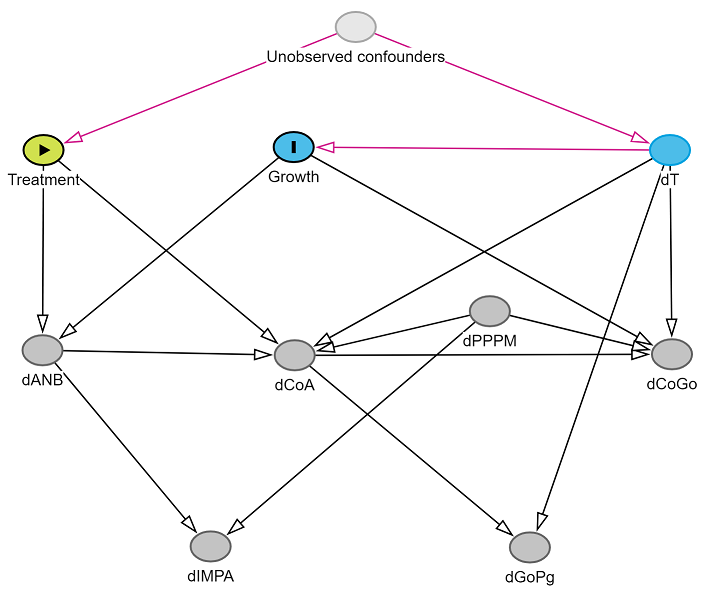

Fig. 4. Causal and biasing paths for outcome Growth

`dT` is the blocker on the path. This factor does not have any descendants on the directed path from `Treatment` to `Growth` (since there is no such path), 2) blocks all undirected paths from `Treatment` to `Growth`, which makes it a valid adjustment set. Since, we cannot account for `Unobserved confounders`, we will not include it in the adjustment set.

So, our variables are:
- $X$ = $\{$ `dT` $\}$;
- $T$ = `Treatment`;
- $Y$ = `Growth`.

In [44]:
X = ['dT']
T = 'Treatment'
Y = 'Growth'

Since there is no direct path between `Treatment` and `Growth`, it looks like there is no much sense in evaluating the causal effect of treatment on outcome. Nonetheless, let's prove or disprove it with statistical methods.

First, as in [2.1](#treat_danb), we will start with the baseline unadjusted average treatment effect (ATE) as a naive estimate. This effect is likely to be biased, since we do not account for other factors, as per our adjustment set.

In [45]:
E_Y_T0 = malocclusion_data[malocclusion_data[T] == 0][Y].mean() # Untreated
E_Y_T1 = malocclusion_data[malocclusion_data[T] == 1][Y].mean() # Treated

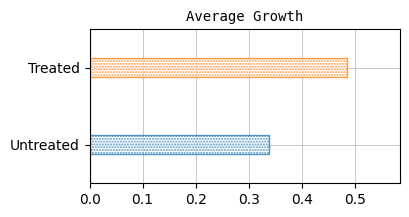

In [46]:
# Visually check average outcome for treated and untreated
plt.figure(figsize=(4, 2))
bars = plt.barh(['Untreated', 'Treated'], [E_Y_T0, E_Y_T1], height=0.25, align='center', color = 'white', alpha=0.75, hatch='.'*6)
plt.vlines(0, -0.5, 1.5, color='C7')
plt.xlim([0, max(E_Y_T1, E_Y_T0) + 0.1])
plt.ylim([-0.5, 1.5])
plt.title(f'Average {Y}', size=10, family='monospace')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
plt.gca().set_axisbelow(True)
plt.grid(lw=0.5)

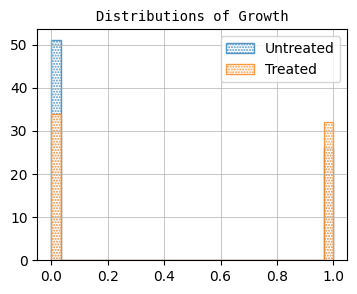

In [47]:
# Visually check difference between distributions of outcome for treated and untreated
plt.figure(figsize=(4, 3))
plt.hist(malocclusion_data[malocclusion_data[T] == 0][Y], bins=30, color = 'white', edgecolor='C0', alpha=0.75, hatch='.'*6, label='Untreated')
plt.hist(malocclusion_data[malocclusion_data[T] == 1][Y], bins=30, color = 'white', edgecolor='C1', alpha=0.75, hatch='.'*6, label='Treated')
plt.title(f'Distributions of {Y}', size=10, family='monospace')
plt.legend()
plt.grid(lw=0.5);

These distributions do not suggest clear difference between the treated and untreated individuals. Both `Treatment` and `Growth` are binary (categorical) variables, thus we can check, if they are independent by using $\chi^2$-test.

In [48]:
observed_df = pd.DataFrame(crosstab(malocclusion_data[T], malocclusion_data[Y]).count)
df_index = ['Untreated', 'Treated']
df_columns = ['Growth_0', 'Growth_1']
observed_df.index = df_index
observed_df.columns = df_columns
observed_df

,Growth_0,Growth_1
Untreated,51,26
Treated,34,32


In [49]:
# No empty cells and no cells with count less than 5, so, we can proceed
result = chi2_contingency(observed_df.values)
print(f'statistic = {result.statistic:.4f}')
if result.pvalue < alpha:
    print(f'p-value   = \033[32m{result.pvalue:.4f}\033[0m ({alpha = })')
else:
    print(f'p-value   = \033[31m{result.pvalue:.4f}\033[0m ({alpha = })')

statistic = 2.6121
p-value   = 0.1061 (alpha = 0.05)


Even without eliminating the bias, we already see, that `Treatment` and `Growth` are rather independent. Let's calculate ATE.

In [50]:
# ATE
ATE_unadj = E_Y_T1 - E_Y_T0
print(f'ATE on {Y} (Unadjusted) = {ATE_unadj:.4f};', end=' ')
# CI
# If we make no assumption about null distribution of ATE, we can use bootstrap to estimate confidence interval
E_Y_T0_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data[malocclusion_data[T] == 0][Y].values, 10000)))
E_Y_T1_boot = list(map(np.mean, resample_via_bootstrap(malocclusion_data[malocclusion_data[T] == 1][Y].values, 10000)))
ATE_unadj_boot = np.array(list(map(lambda x: x[0] - x[1], zip(E_Y_T1_boot, E_Y_T0_boot))))
ci = percentile_interval(ATE_unadj_boot, alpha)
print(f'95% CI (bootstrap) = [{ci[0]:.4f}, {ci[1]:.4f}]')
# To understand, if ATE is statistically significant, let's assume that null distribution of ATE is Student's t-distribution
# Our individuals are not matched yet, so we'll use two-sample independent t-test
ATE_unadj_lo, ATE_unadj_hi = t_test(malocclusion_data[malocclusion_data[T] == 1][Y], malocclusion_data[malocclusion_data[T] == 0][Y], 'ind')
# Note, that CIs obtained by bootstrapping and t-test are close

ATE on Growth (Unadjusted) = 0.1472; 95% CI (bootstrap) = [-0.0130, 0.3074]
t-test summary:
statistic = 1.7946
p-value   = 7.49e-02 (alpha = 0.05)
95% CI    = [-0.0150, 0.3093]


In [51]:
# ATET
ATET_unadj = ATE_unadj
print(f'ATET on {Y} (Unadjusted) = {ATET_unadj:.4f};', end=' ')
# CI
ATET_unadj_lo, ATET_unadj_hi = ATE_unadj_lo, ATE_unadj_hi
print(f'95% CI (t) = [{ATET_unadj_lo:.4f}, {ATET_unadj_hi:.4f}]')

ATET on Growth (Unadjusted) = 0.1472; 95% CI (t) = [-0.0150, 0.3093]


Notes:
- ATE / ATET are _not_ statistically significant;
- confidence interval spans over both positive and negative values, which is ambiguous: is effect positive and negative at the same time?

We already understand, that based on our data, `Treatment` has no causal effect on `Growth`. Anyway, let's apply the same adjustment methods, as in [2.1](#treat_danb) and briefly discuss their results.

1. Ordinary Linear Regression (OLS)

In [52]:
# Fit OLS
model_linreg = smf.ols(f"{Y} ~ {' + '.join([T] + X)}", data=malocclusion_data)
fitted = model_linreg.fit()
print(fitted.summary(), end='\n\n')
if fitted.pvalues[T] < alpha:
    print(f"{T}'s p-value = \033[32m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })")
else:
    print(f"{T}'s p-value = \033[31m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })")

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.433
Date:                Tue, 24 Oct 2023   Prob (F-statistic):             0.0350
Time:                        14:41:32   Log-Likelihood:                -97.770
No. Observations:                 143   AIC:                             201.5
Df Residuals:                     140   BIC:                             210.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4623      0.086      5.382      0.0

Notes:
- `Treatment` is a statistically significant factor;
- $R^2 \approx 0.05$, which is very low, i.e. linear model is a bad estimator and should not be trusted;
- `dT` is a statistically _non_-significant factor. In this case we should exclude this factor from our adjustment set and repeat. But we'll have an empty adjustment set in this case, which makes adjustment methods with matching not applicable. So, we can only repeat the OLS method, which in fact should return the same results as the unadjusted naive estimate method.

In [53]:
X.remove('dT') # remove `dT` as non-significant
X

[]

In [54]:
# Fit OLS once again
model_linreg = smf.ols(f"{Y} ~ {' + '.join([T] + X)}", data=malocclusion_data)
fitted = model_linreg.fit()
print(fitted.summary(), end='\n\n')
if fitted.pvalues[T] < alpha:
    print(f"{T}'s p-value = \033[32m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })")
else:
    print(f"{T}'s p-value = \033[31m{fitted.pvalues[T]:.2e}\033[0m ({alpha = })")

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.221
Date:                Tue, 24 Oct 2023   Prob (F-statistic):             0.0749
Time:                        14:41:32   Log-Likelihood:                -99.578
No. Observations:                 143   AIC:                             203.2
Df Residuals:                     141   BIC:                             209.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3377      0.056      6.060      0.0

Notes:
- this time `Treatment` is a statistically _non_-significant factor;
- $R^2 \approx 0.02$, which is now even smaller.

Answer:
- final adjustment set of covariates is $X = \{ \emptyset \}$;
- linear adjustment model has very low $R^2$ and thus cannot be trusted;
- both unadjusted biased and "adjusted" on empty `X` with OLS ATE / ATET = 0.1472 with 95% CI = [-0.015, 0.3093] obtained under null t-distribution assumption, and bootstrap yields similar CI;
- confidence interval spans over both positive and negative values, which is ambiguous: is the effect positive and negative at the same time?
- all considered methods proved the statistical _non_-significance of ATE / ATET.

---
##### <a id="discussion"></a>3. Discussion

We have confirmed statistically significant causal effect of `Treatment` on `dANB` adjusted for `Growth` with MDM / PSM. ATET = 1.8523 is slightly less than ATE = 1.8564. Though this may seem counter-intuitive, the difference may come from the data. There are only 143 individuals assigned to groups of unequal sizes: 66 in treatment vs. 77 in control. Was the assignment of individuals truly random?

We have confirmed statistically _non_-significant causal effect of `Treatment` on `Growth`, which was expected, as per the DAG in Fig. [2](#dag). A quick caution: we did not reject $H_0$ (no effect), but this does not mean that we should accept it. No effect might be due to inconsistent or incomplete data. In other words, all results obtained in this analysis are valid for the provided data only. 